
Wind Predictions - Linear Regression

Variables to Consider 

Windgust, windspeed,	winddir, severerisk, precip, humidity

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# Not relative path - change if other user please
data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/combined_fuel_weather_data.csv')
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
# Create a new copy for increased efficiency
wind_data = data[['BeginDate', 'Wind','Previous_Year']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_65020\2634972938.py:2: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/combined_fuel_weather_data.csv')


In [45]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Wind'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['BeginDate'] - pd.Timedelta(days=1)
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [46]:
def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Wind'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [47]:
def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Wind'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [48]:
data['Previous_Year_Wind'] = data.apply(get_previous_year_Wind, axis=1, reference_df=wind_data)
cutoff_date = pd.to_datetime("2023-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
usable_data['Previous_Day_Wind'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=wind_data)
usable_data['Previous_2Day_Wind'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=wind_data)

In [49]:
#Splitting the data and new columns
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Month'] = usable_data['BeginDate'].dt.month
# Splitting data by date: first 29 days for training, last day for testing
train_data = usable_data[usable_data['BeginDate'] <= '2024-10-24']

# Filter for test data: starting from September 29, 2024 onward
test_data = usable_data[usable_data['BeginDate'] > '2024-10-24']

Seems like wind output lag 2 and direction are not very correlated

In [50]:
features = ['Hour_of_Day','Sum','Month','Previous_Day_Wind','Previous_2Day_Wind', 'windspeed', 'windgust', 'cloudcover', 'severerisk', 'precip', 'humidity', 'Previous_Year_Wind','winddir','dew']
X_train = train_data[features]
Y_train = train_data['Wind']
X_test = test_data[features]
Y_test = test_data['Wind']

In [51]:
# Initialize and train the Linear Regression
regression = LinearRegression()
regression.fit(X_train, Y_train)

LinearRegression()

In [52]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
#Predict using model and rmse
predictions = regression.predict(X_test)
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(Y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 132.2128258393619
Mean Squared Error (MSE): 30597.155112455584
Root Mean Squared Error (RMSE): 174.92042508653924
Percent Error (PERR): 0.2651219064048899


In [53]:
#View coefficients
coefficients = zip(X_train.columns, regression.coef_)

for feature, coef in coefficients:
    print(f"{feature}: {coef}")

Hour_of_Day: -4.082047578651202
Sum: 0.002736158267973363
Month: 0.9614086564395362
Previous_Day_Wind: 0.19481732617497094
Previous_2Day_Wind: 0.03306923160383097
windspeed: 0.778325057163031
windgust: 15.724229340925664
cloudcover: -0.9889014827492266
severerisk: -1.919711010890883
precip: 5.342278845783722
humidity: -0.2890947902638971
Previous_Year_Wind: 0.05467288099614975
winddir: 0.39411387886456767
dew: -2.5680990229906127


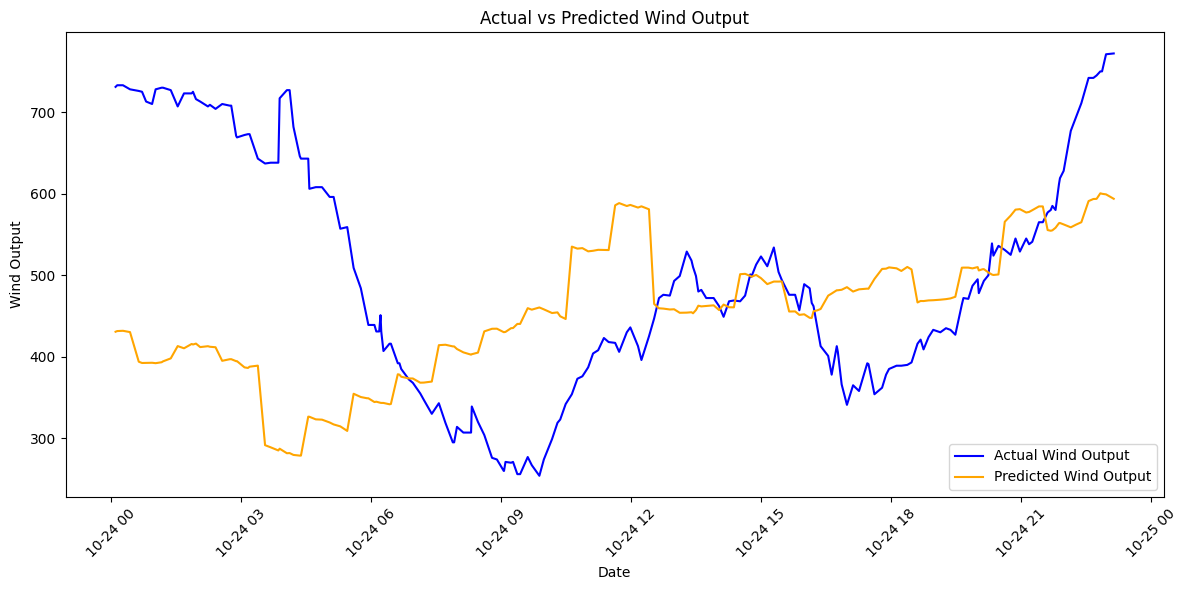

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['BeginDate'], Y_test, label='Actual Wind Output', color='blue')
plt.plot(test_data['BeginDate'], predictions, label='Predicted Wind Output', color='orange')
plt.xlabel('Date')
plt.ylabel('Wind Output')
plt.title('Actual vs Predicted Wind Output')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()